# Calculate the matrix $K$ in a second manner
The matrix $K$ is the Hessian of the harmonic bond potential
$$V_B = \sum_{i,j\in \mathbf{B}} \frac{k_{i,j}}{2}(r_{i,j}-\bar{r_{i,j}})^2,$$
with $r_{i,j}$ the euclidean distance between particles $i$ and $j$. The set of bonded particles $\mathbf{B}$ contains tuples, where the order matters!

In [1]:
from openff.toolkit import Molecule, Topology, ForceField
from openff.interchange import Interchange
from openmm.unit import kelvin, picoseconds, nanometer, kilojoule, mole, dalton, angstrom, kilocalorie, nanosecond, femtosecond, dimensionless
from openmm import LangevinIntegrator, State, VerletIntegrator
from openmm.app import Simulation, DCDReporter, StateDataReporter, CheckpointReporter
from openmm.unit.quantity import Quantity
from sys import stdout
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import copy

In [2]:
from openmm.app.forcefield import ForceField as OpenMMForceField
from openmm.app import PDBFile

In [3]:
### 3. Choose parameters of the experiment
temperature = 100*kelvin
frictionCoeff = 0  # 1/picoseconds
time_step = 0.0002*picoseconds
total_steps = int(1*picoseconds / time_step)

smiles_explicit_h = Molecule.from_smiles(
    #"[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]",
    #"N1N=NN=N1",
    "[H]O[H]",
    #"N#N",
    hydrogens_are_explicit=False,
)
smiles_explicit_h.generate_conformers(n_conformers=1)

sage = ForceField("openff_unconstrained-2.1.0.offxml")
interchange = Interchange.from_smirnoff(sage, [smiles_explicit_h])

positions = interchange.positions.to_openmm()
system = interchange.to_openmm_system()
topology = Topology.from_molecules([smiles_explicit_h])

original_positions = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions())
original_positions_numpy = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions(True))
print(original_positions)

[Vec3(x=-0.07890016058553162, y=-0.019816431697328638, z=-0.0), Vec3(x=-0.0006127160367289928, y=0.03917363361295281, z=-0.0), Vec3(x=0.07951287662226064, y=-0.01935720191562418, z=0.0)] nm


In [4]:
integrator = VerletIntegrator(time_step)
simulation = Simulation(topology.to_openmm(), system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()

In [5]:
original_positions = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions())
original_positions_numpy = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions(True))
print(original_positions)

[Vec3(x=-0.07890016058553162, y=-0.019816431697328638, z=-0.0), Vec3(x=-0.0006127160367289928, y=0.03917363361295281, z=-0.0), Vec3(x=0.07951287662226064, y=-0.01935720191562418, z=0.0)] nm


In [6]:
bonds = sage.get_parameter_handler("Bonds").find_matches(topology, unique=True)  # k units: kCal / Angstrom **2 / mole; length units: Angstrom
m = Quantity(np.array([[atom.mass.m] for atom in topology.atoms]), dalton)   # Dalton


In [7]:
import scipy


def compute_jacobian(positions: np.array, bonds:dict, topology: Topology):
    '''The function computes the Hessian of the harmonic potential evaluated
    at the initial positions of the particles.
    '''
    n = positions.size
    K = Quantity(np.zeros((n, n)), unit=kilocalorie / (mole * angstrom**2))
    for i in range(topology.n_atoms):
        for j in range(i + 1, topology.n_atoms):
            if bonds.get((i,j)):
                k = bonds.get((i,j))\
                .parameter_type.k.to_openmm()#\
                #.value_in_unit(kilocalorie/(angstrom**2*mole))
                r0 = bonds.get((i,j))\
                .parameter_type.length.to_openmm()#\
                #.value_in_unit(nanometer)    
                difference = positions[i] - positions[j]
                distance = Quantity(np.linalg.norm(difference), difference.unit)
                K_small = k * distance ** (-2)\
                        * (-1 + (distance - r0) * distance ** (-1))\
                        * Quantity(np.outer(difference, difference), difference.unit ** 2)
                add_for_diag = k * -(distance - r0) * distance ** (-1)
                K_small += Quantity(np.diag(np.ones(3) * add_for_diag), add_for_diag.unit)
                K[i * 3: (i + 1) * 3, j * 3: (j + 1) * 3] = K_small 
                #import pdb; pdb.set_trace()
                K[j * 3: (j + 1) * 3, j * 3: (j + 1) * 3] -= K_small / 2
                K[i * 3: (i + 1) * 3, i * 3: (i + 1) * 3] -= K_small / 2  # / 2 because of later + transpose
    K = K + Quantity(K.transpose(), unit=K.unit)
    return K

In [8]:
def compute_bond_potential(positions, bonds, topology):
    potential = Quantity(0, kilocalorie/mole)
    for i in range(topology.n_atoms):
        for j in range(i + 1, topology.n_atoms):
            if bonds.get((i,j)):
                k = bonds.get((i,j))\
                .parameter_type.k.to_openmm()#\
                #.value_in_unit(kilocalorie/(angstrom**2*mole))
                r0 = bonds.get((i,j))\
                .parameter_type.length.to_openmm()#\
                #.value_in_unit(nanometer)    
                difference = positions[i] - positions[j]
                distance = Quantity(np.linalg.norm(difference), nanometer)
                potential += (k / 2) * (distance - r0) ** 2
    return potential

def compute_bond_force(positions, bonds, topology):
    n = positions.size
    f = Quantity(np.zeros_like(positions), kilocalorie/(angstrom * mole))
    for i in range(topology.n_atoms):
        for j in range(i + 1, topology.n_atoms):
            if bonds.get((i,j)):
                k = bonds.get((i,j))\
                .parameter_type.k.to_openmm()#\
                #.value_in_unit(kilocalorie/(angstrom**2*mole))
                r0 = bonds.get((i,j))\
                .parameter_type.length.to_openmm()#\
                #.value_in_unit(nanometer)    
                difference = positions[i] - positions[j]
                distance = Quantity(np.linalg.norm(difference), nanometer)
                f[i] += k * (distance - r0) * distance ** (-1) * difference
                f[j] -= k * (distance - r0) * distance ** (-1) * difference
    return f

In [9]:
#M_sqrt = np.kron(np.diag(np.sqrt(m.flatten())), np.eye(3))
#M_sqrt_inv = np.kron(np.diag(1 / np.sqrt(m.flatten())), np.eye(3))
M_sqrt = Quantity(np.kron(np.diag(np.sqrt(m.flatten())), np.eye(3)), m.unit ** (1/2))
M_sqrt_inv = Quantity(np.kron(np.diag(1 / np.sqrt(m.flatten())), np.eye(3)), m.unit ** (-1/2))

def matvec_quantity(A, b, transA=False):
    unit = A.unit * b.unit
    if transA:
        A = Quantity(A.T, A.unit)
    value = A.value_in_unit(A.unit) @ b.value_in_unit(b.unit).reshape(-1)
    return Quantity(value, unit)

def matmul_quantity(A, B):
    unit = A.unit * B.unit
    value = A.value_in_unit(A.unit) @ B.value_in_unit(B.unit)
    return Quantity(value, unit)

In [10]:
newp = copy.deepcopy(original_positions_numpy)
newp[0][0] += Quantity(0.000005, nanometer)
new_pot = compute_bond_potential(newp, bonds, topology)
diff = newp - original_positions_numpy
app_pot = compute_bond_potential(original_positions_numpy, bonds, topology) \
            + matvec_quantity(compute_bond_force(original_positions_numpy, bonds, topology).reshape(-1), diff, True) \
            + 1/2 * matvec_quantity(matvec_quantity(compute_jacobian(original_positions_numpy, bonds, topology), diff.reshape(-1)), diff.reshape(-1), True).reduce_unit()
print(new_pot)
print(app_pot)
print(new_pot - app_pot)

0.06688451570735185 kcal/mol
0.06688451572709911 kcal/mol
-1.9747259383251503e-11 kcal/mol


In [11]:
k = bonds.get((0,1))\
.parameter_type.k.to_openmm()#\
#.value_in_unit(kilocalorie/(angstrom**2*mole))
r0 = bonds.get((0,1))\
.parameter_type.length.to_openmm()

In [12]:
k, r0

(Quantity(value=1069.809209734, unit=kilocalorie/(angstrom**2*mole)),
 Quantity(value=0.981124525388, unit=angstrom))

In [13]:
r0 - Quantity(np.linalg.norm(original_positions_numpy[0] - original_positions_numpy[1]), nanometer), (original_positions_numpy[0] - original_positions_numpy[1])

(Quantity(value=0.0008821176493265526, unit=angstrom),
 Quantity(value=array([-0.07828744, -0.05899007,  0.        ]), unit=nanometer))

In [14]:
original_positions_numpy[1][0] = original_positions_numpy[0][0] + r0

In [15]:
K = compute_jacobian(original_positions_numpy, bonds, topology)

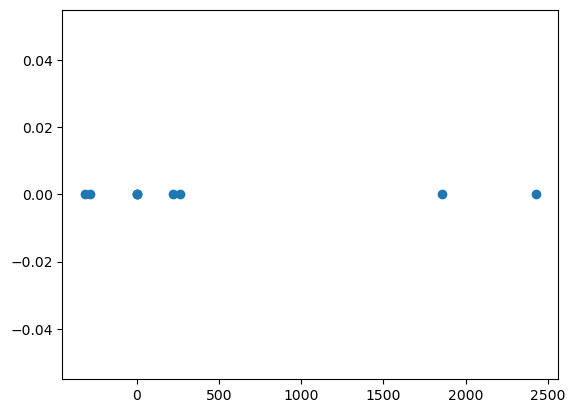

In [16]:
eigvals = scipy.linalg.eigvals(K)
plt.scatter(np.real(eigvals), np.imag(eigvals))

In [17]:
sorted(np.real(eigvals))

[-314.1998955774336,
 -281.1579804841642,
 -2.2213490914379726e-14,
 1.3663433758840268e-14,
 3.747870120518774e-14,
 222.6641414369733,
 261.7201109786512,
 1858.2915631023868,
 2426.95933028202]

In [18]:
import pandas as pd
pd.DataFrame(K)

,0,1,2,3,4,5,6,7,8
0,826.370924,404.887282,0.000000,-826.370924,-404.887282,0.000000,0.000000,0.000000,0.000000
1,404.887282,396.399475,0.000000,-404.887282,-396.399475,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,152.961189,0.000000,0.000000,-152.961189,0.000000,0.000000,0.000000
3,-826.370924,-404.887282,0.000000,1290.272298,-219.340895,0.000000,-463.901374,624.228177,0.000000
4,-404.887282,-396.399475,0.000000,-219.340895,823.106229,0.000000,624.228177,-426.706754,0.000000
5,0.000000,0.000000,-152.961189,0.000000,0.000000,-26.239892,0.000000,0.000000,179.201081
6,0.000000,0.000000,0.000000,-463.901374,624.228177,0.000000,463.901374,-624.228177,0.000000
7,0.000000,0.000000,0.000000,624.228177,-426.706754,0.000000,-624.228177,426.706754,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,179.201081,0.000000,0.000000,-179.201081


In [19]:
pd.DataFrame(KK)

NameError: name 'KK' is not defined

In [ ]:
K.unit, KK.unit

[-314.1998955774337,
 -281.157980484164,
 -1.2033564567779271e-13,
 -1.2033564567779271e-13,
 -1.4758803236202455e-14,
 222.6641414369737,
 261.7201109786514,
 1858.2915631023839,
 2426.9593302820235]

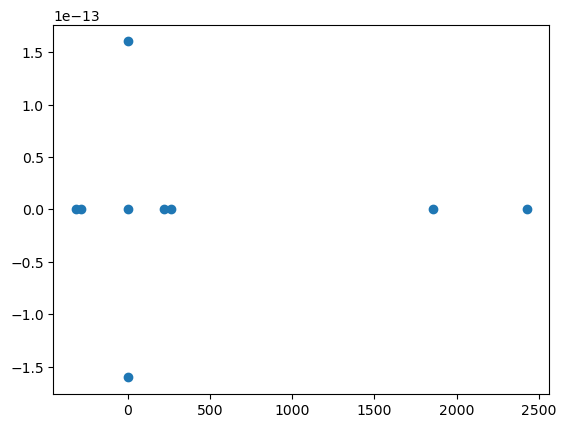

In [20]:
Omega2 = matmul_quantity(M_sqrt_inv, matmul_quantity(K, M_sqrt))
eigvals = scipy.linalg.eigvals(Omega2)
plt.scatter(np.real(eigvals), np.imag(eigvals))
sorted(np.real(eigvals))

In [21]:
def compute_hessian_v2(r_ini, bonds, topology):
    '''The function computes the Jacobian of the spring force evaluated
    at the initial positions of the particles.
    Source: https://victoriacity.github.io/hessian/'''
    n = np.size(r_ini)
    K = Quantity(np.zeros((n, n)), kilocalorie / (mole * angstrom**2))
    for i in range(topology.n_atoms):
        for j in range(topology.n_atoms):
            RiRj = (r_ini[i] - r_ini[j]).value_in_unit(angstrom)
            rij = np.linalg.norm(RiRj) ** 2
            if bonds.get((i,j)):
                k = bonds.get((i,j))\
                .parameter_type.k.to_openmm()
                r0 = bonds.get((i,j))\
                .parameter_type.length\
                .to_openmm().value_in_unit(angstrom) **2
                l = -4 * k * np.outer(RiRj, RiRj)
                r = -2 * k * (rij - r0) * np.eye(3)
                K[i * 3: (i+1) * 3, j * 3: (j+1) * 3] = l + r
                K[i * 3: (i+1) * 3, i * 3: (i+1) * 3] -= l + r
    return K

In [22]:
KK = compute_hessian_v2(original_positions_numpy, bonds, topology)

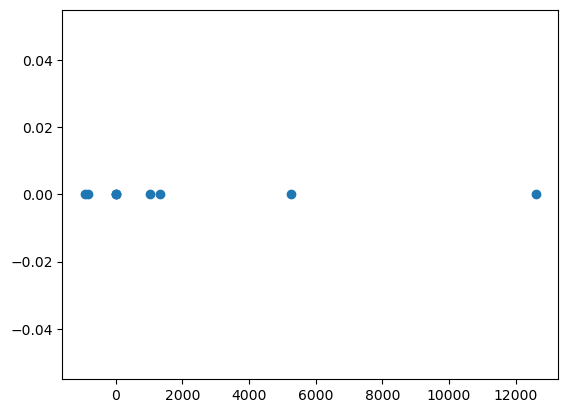

In [23]:
eigvals = scipy.linalg.eigvals(KK)
plt.scatter(np.real(eigvals), np.imag(eigvals))

In [24]:
sorted(np.real(eigvals))

[-928.2381798329144,
 -845.0288206419872,
 -4.1010801441351626e-13,
 4.599556179884229e-14,
 2.5931055151335666e-13,
 1032.7626173329684,
 1320.1279855907464,
 5250.588632903082,
 12606.101625313888]

[-928.2381798329136,
 -845.0288206419875,
 -2.657249904975899e-13,
 -1.63482057046096e-13,
 3.3706266969178976e-14,
 1032.7626173329686,
 1320.127985590747,
 5250.588632903079,
 12606.101625313891]

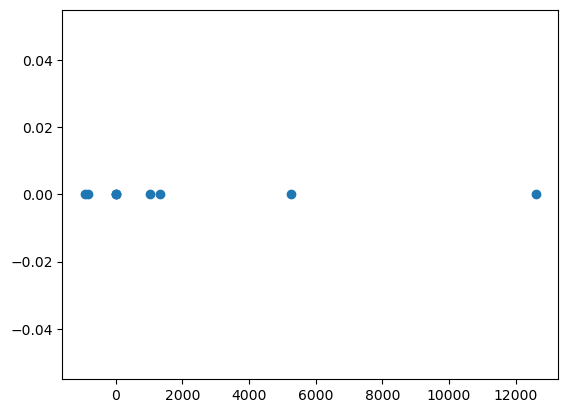

In [25]:
Omega2 = matmul_quantity(M_sqrt_inv, matmul_quantity(KK, M_sqrt))
eigvals = scipy.linalg.eigvals(Omega2)
plt.scatter(np.real(eigvals), np.imag(eigvals))
sorted(np.real(eigvals))

In [ ]:
pd.DataFrame(KK)

## Krylov based Eigenvalue decomposition?
Instead of trying to explicitly calculate the function $\exp(\Omega))$ we calculate the Hessenberg $H_m$ for $\Omega^2$ and then perform $f: x\rightarrow \sqrt(x)$ on that. Or first just calculate the Ritz values.

In [32]:
w = scipy.sparse.linalg.eigsh(Omega2.T.T, return_eigenvectors=False, mode="SM")

In [33]:
sorted(w)

[-9175.77749914631,
 -823.4153741169713,
 850.9828016806432,
 1369.6063642021534,
 5207.2146065135075,
 21442.81787656928]

In [34]:
Omega2.shape

(9, 9)